# CNN-LSTM on IAM lines

## Main Resources

- <a id="1">[1]</a> https://github.com/Sagar-modelling/Handwriting_Recognition_CRNN_LSTM
    - Recognizes words     
    - uses a wrapper model to find ctc loss
    - input: (128px,32px), output: sequence of max. 31 characters
    - kinda clear workflow and explanation
- <a id="2">[2]</a> https://github.com/sushant097/Handwritten-Line-Text-Recognition-using-Deep-Learning-with-Tensorflow
    - Recognizes lines of text
    - input: (800px,64px), output: sequence of max 100(?) characters
    - but it's tf v1    
- <a id="3">[3]</a> https://stackoverflow.com/questions/60285167/tensorflow-callback-as-custom-metric-for-ctc
    - CER & WER metrics implemented (has to rewrite them tho)

## Replicate the process

Let's import some libs and define some constants

In [1]:
import cv2, os, math, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw

2024-02-19 15:32:50.649855: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 15:32:50.649983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 15:32:50.771069: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
characters = " !\"#%&'()*+,-./0123456789:;>?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz" # +"ĂÂÎȘȚăâîșț"
dataset_path = "/kaggle/input/flex-iam-lines/IAM_lines/"

IMG_SIZE = (64, 1024)
SEQ_LEN = 100
np.random.seed(2024)

- ```IMG_SIZE``` is the size of the input images into the network
- ```SEQ_LEN``` is the maximum number of characters that we assume exist on a single line

### Fetching dataset

We are using a customly organized version of the IAM dataset. It consists of a collection of paired files (`n.png`, `n.txt`), where `n` is a natural number. `n.png` is an image containing the cropped line and `n.txt` represents the text written on that line.

In [3]:
"""
Converts a string to an array of labels.
Each character is mapped to an integer label that marks its 
position in the `characters` string.
The resulted array is padded up to `SEQ_LEN` with a constant 
value (has the same value with the so-called "CTC blank label").
"""
def text_to_labels(text:str):
    char_ids = []
    for c in text:
        cid = characters.find(c)
        if cid<0:
            print(f"Warning: undefined character `{c}`")
        else:
            char_ids.append(cid)
    while(len(char_ids)<SEQ_LEN):
        char_ids.append(len(characters))
    return np.array(char_ids)    

In [4]:
"""
Resizes an image to fit into the `IMG_SIZE` bounds, attempting 
to keep aspect ratio if the input is not too wide.
"""
def im_resize(img):
    h, w = img.shape
    H, W = IMG_SIZE
    new_img = cv2.resize(img, (w*H//h, H), interpolation=cv2.INTER_CUBIC)    
    if new_img.shape[1] < W:
        pad_len = W - new_img.shape[1]
        left = math.floor(np.random.rand()*pad_len)
        right = pad_len-left
        new_img = np.pad(new_img, ((0,0), (left, right)), mode="maximum")
    elif new_img.shape[1] > W:
        new_img = cv2.resize(new_img, (W, H))
    return new_img

In [5]:
"""
Increases constrast and makes lines thicker in an image
"""
def enhance(img):
    pxmin = np.min(img)
    pxmax = np.max(img)
    imgContrast = (img - pxmin) / (pxmax - pxmin) * 255    
    kernel = np.ones((3, 3), np.uint8)
    return cv2.erode(imgContrast, kernel, iterations=1) # increase linewidth

Now we're ready to load the dataset into memory.
- Plain loading as numpy arrays, no generators, no data augmentation for now
- `x_train[i]` represents the input image
- `y_true[i]` represents the (labeled) output of `x_train[i]`
- `y_len[i]` tells the number of (useful/effective) characters in `y_true[i]`, considering that the original strings were all padded up to the same length. This value is needed in computing the CTC loss and is also known as the **label length**

In [6]:
x_train, y_true, y_len = [], [], []

k = 0
for root, dirs, files in os.walk(dataset_path, topdown=False):
    for name in files:
        if name.endswith(".png"):            
            img = cv2.imread(os.path.join(root, name), cv2.IMREAD_GRAYSCALE)
            img = enhance(img)                                    
            img = im_resize(img)            
            img = np.reshape(img, IMG_SIZE+(1,))
            with open(os.path.join(root, name[:-4]+".txt"), "r") as f:
                txt = f.read()

            tlabels = text_to_labels(txt)        
            y_true.append(tlabels)
            y_len.append([len(txt)])
                       
            x_train.append(img/255.)

            k += 1
            print(f"\rLoaded {k} images", end="")

            #if k==100: break
print()

# "Seal" the lists into numpy arrays
x_train, y_true, y_len = np.array(x_train), np.array(y_true), np.array(y_len) 

Loaded 13353 images


In [7]:
# Shuffle data

np.random.seed(2024)

def shuffle(arrs):
    l = arrs[0].shape[0]    
    ix = np.array(list(range(l)))        
    np.random.shuffle(ix)
    return tuple(map(lambda c:c[ix], arrs))    

x_train, y_true, y_len = shuffle([x_train, y_true, y_len])

x_train.shape, y_true.shape, y_len.shape

((13353, 64, 1024, 1), (13353, 100), (13353, 1))

- We also need a dummy output value for the wrapper model, let's call it `y_train`. 

In [8]:
y_train = np.zeros(y_len.shape)
y_train.shape

(13353, 1)

### Input preview

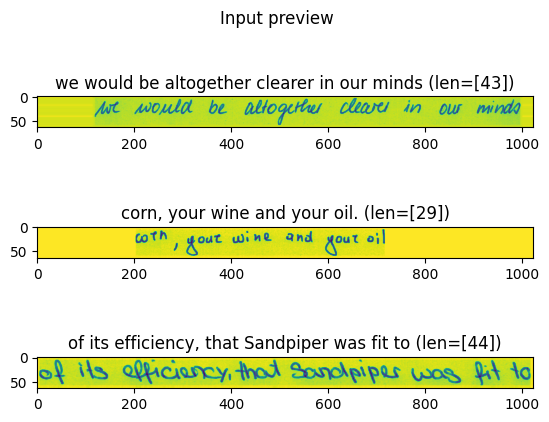

In [9]:
def preview_input(n=3):
    fig, axs = plt.subplots(n)
    fig.suptitle('Input preview')    

    for i in range(n):
        axs[i].imshow(x_train[i])
        text = "".join([characters[c] for c in y_true[i] if c<len(characters)])        
        axs[i].set_title(f"{text} (len={y_len[i]})")
    plt.show()

preview_input(3)

## Recognition model

The recognition model takes the input through a series of convolutional layers, before finally sending the features to a BiLSTM layer.

In [10]:
def create_recognition_model(img_size, labels_len):               
    x = x_input = tf.keras.layers.Input(shape=(*img_size, 1), name='x_input')
        
    x = tf.keras.layers.Conv2D(64, kernel_size=(5,5), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.01)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    
    x = tf.keras.layers.Conv2D(128, kernel_size=(5,5), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.01)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,1))(x)
    
    x = tf.keras.layers.Conv2D(128, kernel_size=(3,3), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.01)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)    
    
    x = tf.keras.layers.Conv2D(256, kernel_size=(3,3), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.01)(x)        
        
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)    
    
    x = tf.keras.layers.Conv2D(512, kernel_size=(3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)                    
    x = tf.keras.layers.LeakyReLU(0.01)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,1))(x)        
    
    x = tf.keras.layers.Conv2D(512, kernel_size=(3,3), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.01)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,1))(x)            
    
    # ----- LSTM -----        
    x = tf.keras.layers.Reshape((-1, 512))(x)          
    
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True))(x)    
    
    x = tf.keras.layers.Reshape((128, 1, -1))(x)
    x = tf.keras.layers.Conv2D(labels_len, kernel_size=(1,1))(x)        
    x = tf.keras.layers.Reshape((-1, labels_len))(x)
    x = tf.keras.layers.Softmax()(x)                
    
    return tf.keras.models.Model(x_input, x)    

In [11]:
recognition_model = create_recognition_model(IMG_SIZE, len(characters)+1)
recognition_model.summary(110)

Model: "model"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 x_input (InputLayer)                            [(None, 64, 1024, 1)]                       0                
                                                                                                              
 conv2d (Conv2D)                                 (None, 64, 1024, 64)                        1664             
                                                                                                              
 leaky_re_lu (LeakyReLU)                         (None, 64, 1024, 64)                        0                
                                                                                                              
 max_pooling2d (MaxPooling2D)                    (None, 32, 512, 64)                         0   

- On the same note as `y_train`, we also need a new tensor that provides the number of timestamps for the CTC loss function. We name it `logit_len`

In [12]:
logit_len = np.full((x_train.shape[0], 1), recognition_model.outputs[0].shape[1])
"Tensor shape:", logit_len.shape, "Timestamps length:", logit_len[0][0]

('Tensor shape:', (13353, 1), 'Timestamps length:', 128)

### Training model

We follow the approach from [[1]](#1), where another model is created which incorporates the recognition model and applies the CTC loss on its output using a separate layer. The reason that leads to this complication resides in the fact that the function that computes the loss (namely `ctc_batch_cost`) needs some additional parameters besides the predicted output, like the label and logit length. Also, the real and predicted outputs have different shapes. This was solved by creating a separate layer for computing the loss function and providing the needed arguments as input layers to the network.


In [13]:
y_true_categorical = tf.keras.utils.to_categorical(y_true)
y_true_categorical.shape

(13353, 100, 82)

In [14]:
def create_train_model(model):
    x_input = tf.keras.layers.Input(shape=model.inputs[0].shape[1:], name='img')
    y_true = tf.keras.layers.Input(shape=(SEQ_LEN,), name='y_true')
    label_len = tf.keras.layers.Input(shape=(1,), name="label_len")    
    logits_len = tf.keras.layers.Input(shape=(1,), name="logits_len")      
    
    y_pred = model(x_input)       
    
    def ctc_layer(data):        
        y_true, y_pred, logit_len, label_len = data               
        return tf.keras.backend.ctc_batch_cost(y_true, y_pred, logit_len, label_len)

    ctc_out = tf.keras.layers.Lambda(ctc_layer, name="ctc")([y_true, y_pred, logits_len, label_len]) 
    
    pred_out = tf.keras.layers.Lambda(lambda x:x, name="pred")(y_pred)
    true_out = tf.keras.layers.Lambda(lambda x:x, name="true")(y_true)
    
    return tf.keras.models.Model([x_input, y_true, label_len, logits_len], [ctc_out, pred_out])    


In [15]:
train_model = create_train_model(recognition_model)

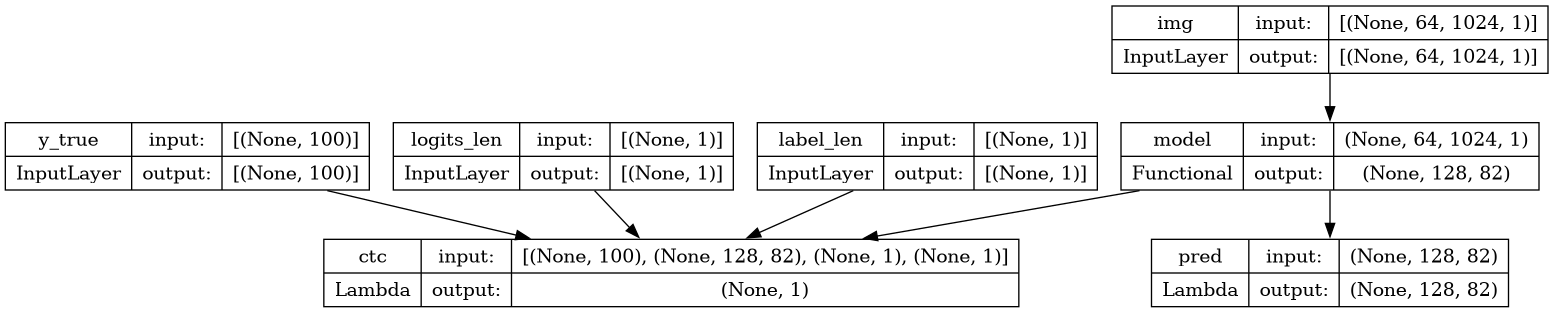

In [16]:
tf.keras.utils.plot_model(train_model, expand_nested=False, show_shapes=True)

The output of the last `Lambda "ctc"` layer will be test against `y_train` values during training. [[1]](#1), the loss function was written as ```lambda y_true, y_pred: y_pred``` (in the given circumstances, this does the same thing as the `MAE` loss, as the "groundtruth" value is always `0`). I also added a projection of the predicted data to compare with the original output, which was converted to a tensor which has the same shape as the output (`y_true_categorical`).

### CER & WER

In [17]:
class CERMetric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the Character Error Rate
    """
    def __init__(self, name='CER_metric', **kwargs):
        super(CERMetric, self).__init__(name=name, **kwargs)
        self.cer_accumulator = self.add_weight(name="total_cer", initializer="zeros")
        self.counter = self.add_weight(name="cer_count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        pred_input_shape = tf.keras.backend.shape(y_pred)
        pred_input_length = tf.ones(shape=pred_input_shape[0]) * tf.keras.backend.cast(pred_input_shape[1], 'float32')
        true_input_shape = tf.keras.backend.shape(y_true)
        true_input_length = tf.ones(shape=true_input_shape[0]) * tf.keras.backend.cast(true_input_shape[1], 'float32')                           
                
        pred, _ = tf.keras.backend.ctc_decode(y_pred, pred_input_length, greedy=True)                
        true, _ = tf.keras.backend.ctc_decode(y_true, true_input_length, greedy=True)        
        
        pred, true = pred[0], true[0]        
        
        pred_length = tf.keras.backend.cast(tf.math.argmin(pred, axis=1), 'int32')
        true_length = tf.keras.backend.cast(tf.math.argmin(true, axis=1), 'int32')                    
        
        pred = tf.keras.backend.ctc_label_dense_to_sparse(pred, pred_length)
        true = tf.keras.backend.ctc_label_dense_to_sparse(true, true_length)
                           
        distance = tf.edit_distance(pred, true, normalize=True)

        self.cer_accumulator.assign_add(tf.reduce_sum(distance))
        self.counter.assign_add(tf.cast(pred_input_shape[0],'float32'))

    def result(self):
        return tf.math.divide_no_nan(self.cer_accumulator, self.counter)

    def reset_state(self):
        self.cer_accumulator.assign(0.0)
        self.counter.assign(0.0)

In [18]:
class WERMetric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the Word Error Rate
    """
    def __init__(self, name='WER_metric', **kwargs):
        super(WERMetric, self).__init__(name=name, **kwargs)
        self.wer_accumulator = self.add_weight(name="total_wer", initializer="zeros")
        self.counter = self.add_weight(name="wer_count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        pred_input_shape = tf.keras.backend.shape(y_pred)
        pred_input_length = tf.ones(shape=pred_input_shape[0]) * tf.keras.backend.cast(pred_input_shape[1], 'float32')
        true_input_shape = tf.keras.backend.shape(y_true)
        true_input_length = tf.ones(shape=true_input_shape[0]) * tf.keras.backend.cast(true_input_shape[1], 'float32')                           
                
        pred, _ = tf.keras.backend.ctc_decode(y_pred, pred_input_length, greedy=True)                
        true, _ = tf.keras.backend.ctc_decode(y_true, true_input_length, greedy=True)        
        
        pred, true = pred[0], true[0]        
        
        pred_length = tf.keras.backend.cast(tf.math.argmin(pred, axis=1), 'int32')
        true_length = tf.keras.backend.cast(tf.math.argmin(true, axis=1), 'int32')                    
        
        pred = tf.keras.backend.ctc_label_dense_to_sparse(pred, pred_length)
        true = tf.keras.backend.ctc_label_dense_to_sparse(true, true_length)
                           
        distance = tf.edit_distance(pred, true, normalize=True)
                
        red_y_true = tf.argmax(y_true, axis=2)        
        
        spaces_mask = tf.equal(red_y_true, tf.zeros((), dtype=tf.int64))
        spaces_count = tf.reduce_sum(tf.cast(spaces_mask, tf.int32), axis=1)        
                
        words_count = tf.add(spaces_count, tf.ones_like(spaces_count))        
        words_count = tf.reduce_sum(words_count)        

        self.wer_accumulator.assign_add(tf.reduce_sum(distance))
        self.counter.assign_add(tf.cast(words_count,'float32'))


    def result(self):
        return tf.math.divide_no_nan(self.wer_accumulator, self.counter)

    def reset_state(self):
        self.wer_accumulator.assign(0.0)
        self.counter.assign(0.0)

### Prepare for training



In [19]:
train_model.compile(optimizer="rmsprop", 
                    loss={
                        'ctc': lambda y_true, y_pred: y_pred                 
                    }, 
                    metrics={
                        'ctc':"accuracy",
                        'pred':[CERMetric(),WERMetric()]
                    })

Let's now define a callback function to be called at the end of each epoch. We are using it to regularly save the model and monitor the state of predictions

In [20]:
def callback_plot(epoch, logs):    
    if epoch%5==0:    
        n=1
        in_img = x_train[:n,:,:,:]
        in_true = y_true[:n,:]
        out_pred = recognition_model.predict(in_img) #tf.math.argmax(recognition_model.predict(in_img), axis=2)                    

        for i in range(n):        
            img = in_img[i]
            true = in_true[i]
            true = "".join([characters[c] for c in true if c<len(characters)])
            pred = out_pred[i]
            
        fig, axs = plt.subplots(2)
        fig.suptitle(true)        
        axs[0].imshow(img)
                
        print(pred.shape)
        
        def label2char(l): 
            c = characters[l] if l<len(characters) else "ε"
            if c==" ": c="\\s"
            return c
        
        for i in range(len(characters)+1):
            yc = pred[:,i]
            im = np.argmax(yc)            
            axs[1].plot(yc)   
            plt.text(im, yc[im], label2char(i))            
        
        plt.show()
            

    if epoch%3==0:
        recognition_model.save_weights("model_lstm_fullscale.h5")

### Training the model

Epoch 1/100


I0000 00:00:1708357086.463809      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 1s 760ms/step
(128, 82)


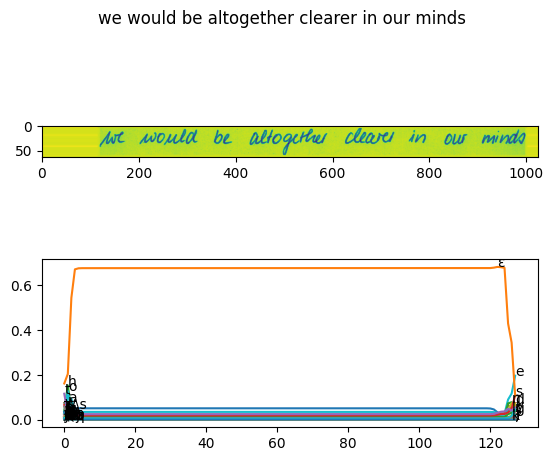

2404/2404 [==============================] - 185s 73ms/step - loss: 135.3734 - ctc_loss: 135.3734 - ctc_accuracy: 0.0000e+00 - pred_CER_metric: 0.9706 - pred_WER_metric: 0.1288 - val_loss: 134.7231 - val_ctc_loss: 134.7231 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 0.9745 - val_pred_WER_metric: 0.1289 - lr: 0.0010
Epoch 2/100
2404/2404 [==============================] - 172s 72ms/step - loss: 134.4220 - ctc_loss: 134.4220 - ctc_accuracy: 0.0000e+00 - pred_CER_metric: 0.9838 - pred_WER_metric: 0.1306 - val_loss: 134.7512 - val_ctc_loss: 134.7512 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 0.9784 - val_pred_WER_metric: 0.1294 - lr: 0.0010
Epoch 3/100
2404/2404 [==============================] - 171s 71ms/step - loss: 134.2534 - ctc_loss: 134.2534 - ctc_accuracy: 0.0000e+00 - pred_CER_metric: 0.9781 - pred_WER_metric: 0.1298 - val_loss: 135.3952 - val_ctc_loss: 135.3952 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 0.9765 - val_pred_WER_metric: 0.1292 - lr: 0.

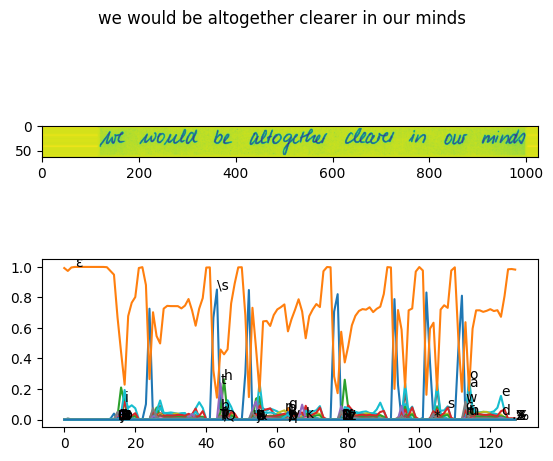

2404/2404 [==============================] - 172s 71ms/step - loss: 131.6841 - ctc_loss: 131.6841 - ctc_accuracy: 0.0000e+00 - pred_CER_metric: 0.9657 - pred_WER_metric: 0.1282 - val_loss: 127.3733 - val_ctc_loss: 127.3733 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 0.8715 - val_pred_WER_metric: 0.1153 - lr: 0.0010
Epoch 7/100
2404/2404 [==============================] - 173s 72ms/step - loss: 58.7639 - ctc_loss: 58.7639 - ctc_accuracy: 0.0000e+00 - pred_CER_metric: 0.3991 - pred_WER_metric: 0.0530 - val_loss: 66.1595 - val_ctc_loss: 66.1595 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 0.4360 - val_pred_WER_metric: 0.0577 - lr: 0.0010
Epoch 8/100
2404/2404 [==============================] - 171s 71ms/step - loss: 25.8712 - ctc_loss: 25.8712 - ctc_accuracy: 0.0012 - pred_CER_metric: 0.1752 - pred_WER_metric: 0.0233 - val_loss: 23.6634 - val_ctc_loss: 23.6634 - val_ctc_accuracy: 0.0015 - val_pred_CER_metric: 0.1597 - val_pred_WER_metric: 0.0211 - lr: 0.0010
Epoch 9/100

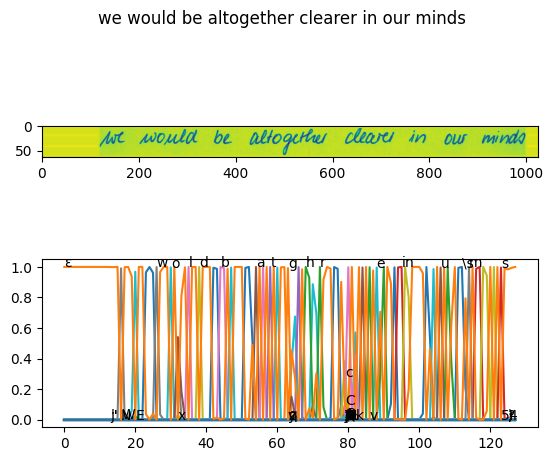

2404/2404 [==============================] - 171s 71ms/step - loss: 15.4209 - ctc_loss: 15.4209 - ctc_accuracy: 0.0184 - pred_CER_metric: 0.1102 - pred_WER_metric: 0.0146 - val_loss: 21.9217 - val_ctc_loss: 21.9217 - val_ctc_accuracy: 0.0112 - val_pred_CER_metric: 0.1425 - val_pred_WER_metric: 0.0188 - lr: 0.0010
Epoch 12/100
2404/2404 [==============================] - 171s 71ms/step - loss: 13.9169 - ctc_loss: 13.9169 - ctc_accuracy: 0.0298 - pred_CER_metric: 0.1018 - pred_WER_metric: 0.0135 - val_loss: 22.1801 - val_ctc_loss: 22.1801 - val_ctc_accuracy: 0.0135 - val_pred_CER_metric: 0.1438 - val_pred_WER_metric: 0.0190 - lr: 0.0010
Epoch 13/100
2404/2404 [==============================] - 171s 71ms/step - loss: 12.6481 - ctc_loss: 12.6481 - ctc_accuracy: 0.0385 - pred_CER_metric: 0.0944 - pred_WER_metric: 0.0125 - val_loss: 19.8319 - val_ctc_loss: 19.8319 - val_ctc_accuracy: 0.0292 - val_pred_CER_metric: 0.1266 - val_pred_WER_metric: 0.0168 - lr: 0.0010
Epoch 14/100
2404/2404 [=====

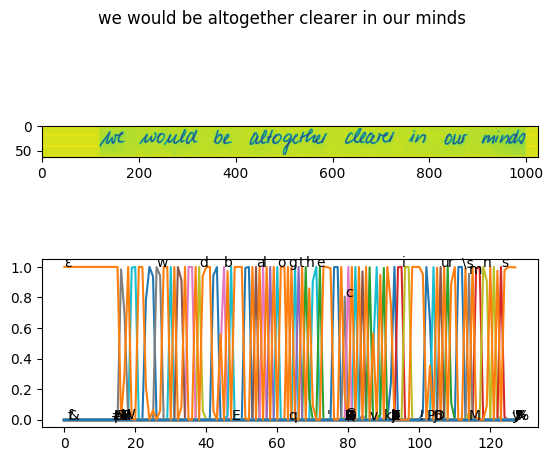

2404/2404 [==============================] - 174s 72ms/step - loss: 9.9893 - ctc_loss: 9.9893 - ctc_accuracy: 0.0727 - pred_CER_metric: 0.0783 - pred_WER_metric: 0.0104 - val_loss: 20.6216 - val_ctc_loss: 20.6216 - val_ctc_accuracy: 0.0546 - val_pred_CER_metric: 0.1116 - val_pred_WER_metric: 0.0148 - lr: 0.0010
Epoch 17/100
2404/2404 [==============================] - 174s 72ms/step - loss: 9.3412 - ctc_loss: 9.3412 - ctc_accuracy: 0.0859 - pred_CER_metric: 0.0741 - pred_WER_metric: 0.0098 - val_loss: 20.5765 - val_ctc_loss: 20.5765 - val_ctc_accuracy: 0.0359 - val_pred_CER_metric: 0.1177 - val_pred_WER_metric: 0.0156 - lr: 0.0010
Epoch 18/100
2404/2404 [==============================] - 174s 72ms/step - loss: 8.7340 - ctc_loss: 8.7340 - ctc_accuracy: 0.1009 - pred_CER_metric: 0.0712 - pred_WER_metric: 0.0095 - val_loss: 23.1706 - val_ctc_loss: 23.1706 - val_ctc_accuracy: 0.0397 - val_pred_CER_metric: 0.1195 - val_pred_WER_metric: 0.0158 - lr: 0.0010
Epoch 19/100
2404/2404 [===========

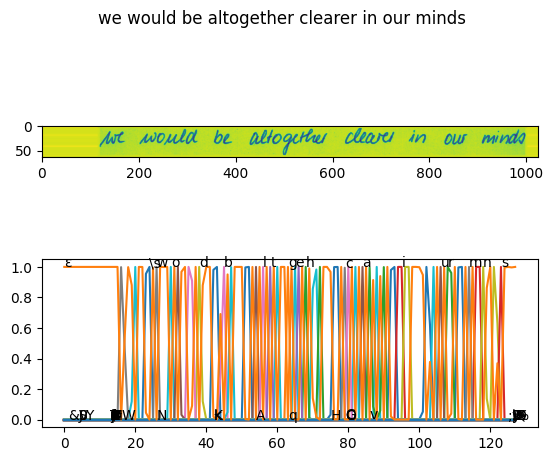

2404/2404 [==============================] - 175s 73ms/step - loss: 7.2132 - ctc_loss: 7.2132 - ctc_accuracy: 0.1464 - pred_CER_metric: 0.0627 - pred_WER_metric: 0.0083 - val_loss: 24.1829 - val_ctc_loss: 24.1829 - val_ctc_accuracy: 0.0629 - val_pred_CER_metric: 0.1152 - val_pred_WER_metric: 0.0152 - lr: 0.0010
Epoch 22/100
2404/2404 [==============================] - 173s 72ms/step - loss: 6.7066 - ctc_loss: 6.7066 - ctc_accuracy: 0.1630 - pred_CER_metric: 0.0598 - pred_WER_metric: 0.0079 - val_loss: 22.8378 - val_ctc_loss: 22.8378 - val_ctc_accuracy: 0.0629 - val_pred_CER_metric: 0.1122 - val_pred_WER_metric: 0.0148 - lr: 0.0010
Epoch 23/100
2404/2404 [==============================] - 171s 71ms/step - loss: 6.3637 - ctc_loss: 6.3637 - ctc_accuracy: 0.1847 - pred_CER_metric: 0.0571 - pred_WER_metric: 0.0076 - val_loss: 22.1830 - val_ctc_loss: 22.1830 - val_ctc_accuracy: 0.0666 - val_pred_CER_metric: 0.1120 - val_pred_WER_metric: 0.0148 - lr: 0.0010
Epoch 24/100
2404/2404 [===========

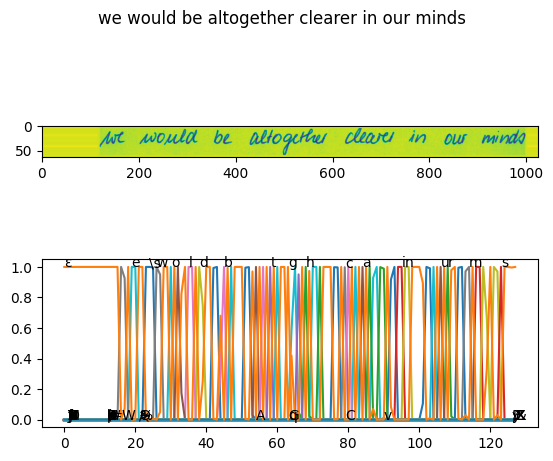

2404/2404 [==============================] - 175s 73ms/step - loss: 5.5120 - ctc_loss: 5.5120 - ctc_accuracy: 0.2277 - pred_CER_metric: 0.0528 - pred_WER_metric: 0.0070 - val_loss: 28.9425 - val_ctc_loss: 28.9425 - val_ctc_accuracy: 0.0681 - val_pred_CER_metric: 0.1195 - val_pred_WER_metric: 0.0158 - lr: 0.0010
Epoch 27/100
2404/2404 [==============================] - 175s 73ms/step - loss: 5.2145 - ctc_loss: 5.2145 - ctc_accuracy: 0.2433 - pred_CER_metric: 0.0508 - pred_WER_metric: 0.0067 - val_loss: 22.8605 - val_ctc_loss: 22.8605 - val_ctc_accuracy: 0.0464 - val_pred_CER_metric: 0.1191 - val_pred_WER_metric: 0.0158 - lr: 0.0010
Epoch 28/100
2404/2404 [==============================] - 172s 72ms/step - loss: 5.0226 - ctc_loss: 5.0226 - ctc_accuracy: 0.2550 - pred_CER_metric: 0.0501 - pred_WER_metric: 0.0066 - val_loss: 26.4736 - val_ctc_loss: 26.4736 - val_ctc_accuracy: 0.0704 - val_pred_CER_metric: 0.1117 - val_pred_WER_metric: 0.0148 - lr: 0.0010
Epoch 29/100
2404/2404 [===========

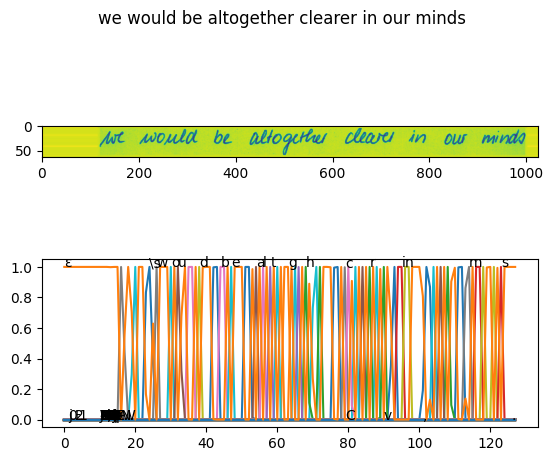

2404/2404 [==============================] - 172s 72ms/step - loss: 4.4463 - ctc_loss: 4.4463 - ctc_accuracy: 0.3022 - pred_CER_metric: 0.0475 - pred_WER_metric: 0.0063 - val_loss: 27.5604 - val_ctc_loss: 27.5604 - val_ctc_accuracy: 0.0861 - val_pred_CER_metric: 0.1120 - val_pred_WER_metric: 0.0148 - lr: 0.0010
Epoch 32/100
2404/2404 [==============================] - 171s 71ms/step - loss: 4.3025 - ctc_loss: 4.3025 - ctc_accuracy: 0.3153 - pred_CER_metric: 0.0465 - pred_WER_metric: 0.0062 - val_loss: 24.1988 - val_ctc_loss: 24.1988 - val_ctc_accuracy: 0.0531 - val_pred_CER_metric: 0.1198 - val_pred_WER_metric: 0.0158 - lr: 0.0010
Epoch 33/100
2404/2404 [==============================] - 171s 71ms/step - loss: 4.1719 - ctc_loss: 4.1719 - ctc_accuracy: 0.3322 - pred_CER_metric: 0.0453 - pred_WER_metric: 0.0060 - val_loss: 28.5242 - val_ctc_loss: 28.5242 - val_ctc_accuracy: 0.0846 - val_pred_CER_metric: 0.1124 - val_pred_WER_metric: 0.0149 - lr: 0.0010
Epoch 34/100
2404/2404 [===========

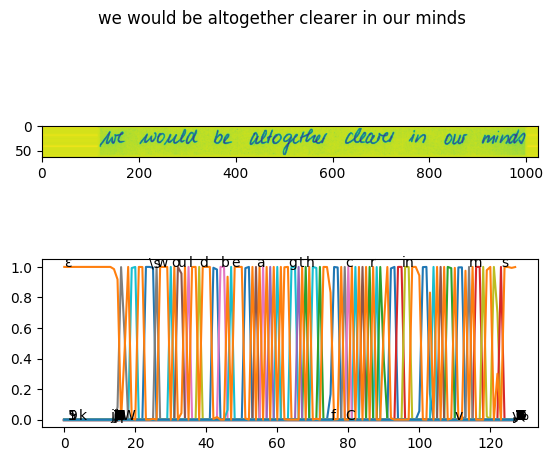

2404/2404 [==============================] - 171s 71ms/step - loss: 3.8613 - ctc_loss: 3.8613 - ctc_accuracy: 0.3682 - pred_CER_metric: 0.0438 - pred_WER_metric: 0.0058 - val_loss: 28.5950 - val_ctc_loss: 28.5950 - val_ctc_accuracy: 0.0524 - val_pred_CER_metric: 0.1272 - val_pred_WER_metric: 0.0168 - lr: 0.0010
Epoch 37/100
2404/2404 [==============================] - 171s 71ms/step - loss: 3.7486 - ctc_loss: 3.7486 - ctc_accuracy: 0.3803 - pred_CER_metric: 0.0431 - pred_WER_metric: 0.0057 - val_loss: 31.6240 - val_ctc_loss: 31.6240 - val_ctc_accuracy: 0.0921 - val_pred_CER_metric: 0.1109 - val_pred_WER_metric: 0.0147 - lr: 0.0010
Epoch 38/100
2404/2404 [==============================] - 171s 71ms/step - loss: 3.6383 - ctc_loss: 3.6383 - ctc_accuracy: 0.3899 - pred_CER_metric: 0.0422 - pred_WER_metric: 0.0056 - val_loss: 31.3766 - val_ctc_loss: 31.3766 - val_ctc_accuracy: 0.0973 - val_pred_CER_metric: 0.1117 - val_pred_WER_metric: 0.0148 - lr: 0.0010
Epoch 39/100
2404/2404 [===========

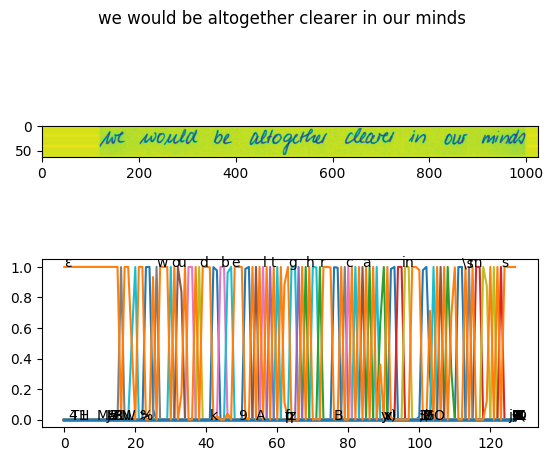

2404/2404 [==============================] - 172s 71ms/step - loss: 3.3799 - ctc_loss: 3.3799 - ctc_accuracy: 0.4090 - pred_CER_metric: 0.0406 - pred_WER_metric: 0.0054 - val_loss: 30.1421 - val_ctc_loss: 30.1421 - val_ctc_accuracy: 0.0853 - val_pred_CER_metric: 0.1151 - val_pred_WER_metric: 0.0152 - lr: 0.0010
Epoch 42/100
2404/2404 [==============================] - 171s 71ms/step - loss: 3.3037 - ctc_loss: 3.3037 - ctc_accuracy: 0.4319 - pred_CER_metric: 0.0404 - pred_WER_metric: 0.0054 - val_loss: 30.6311 - val_ctc_loss: 30.6311 - val_ctc_accuracy: 0.0988 - val_pred_CER_metric: 0.1098 - val_pred_WER_metric: 0.0145 - lr: 0.0010
Epoch 43/100
2404/2404 [==============================] - 171s 71ms/step - loss: 3.2503 - ctc_loss: 3.2503 - ctc_accuracy: 0.4416 - pred_CER_metric: 0.0403 - pred_WER_metric: 0.0054 - val_loss: 34.2078 - val_ctc_loss: 34.2078 - val_ctc_accuracy: 0.0913 - val_pred_CER_metric: 0.1133 - val_pred_WER_metric: 0.0150 - lr: 0.0010
Epoch 44/100
2404/2404 [===========

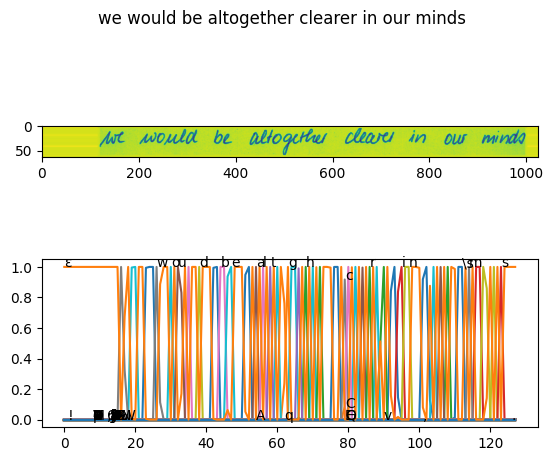

2404/2404 [==============================] - 174s 73ms/step - loss: 3.0241 - ctc_loss: 3.0241 - ctc_accuracy: 0.4616 - pred_CER_metric: 0.0391 - pred_WER_metric: 0.0052 - val_loss: 32.5428 - val_ctc_loss: 32.5428 - val_ctc_accuracy: 0.0981 - val_pred_CER_metric: 0.1093 - val_pred_WER_metric: 0.0145 - lr: 0.0010
Epoch 47/100
2404/2404 [==============================] - 171s 71ms/step - loss: 3.0502 - ctc_loss: 3.0502 - ctc_accuracy: 0.4697 - pred_CER_metric: 0.0384 - pred_WER_metric: 0.0051 - val_loss: 31.3636 - val_ctc_loss: 31.3636 - val_ctc_accuracy: 0.0981 - val_pred_CER_metric: 0.1138 - val_pred_WER_metric: 0.0150 - lr: 0.0010
Epoch 48/100
2404/2404 [==============================] - 171s 71ms/step - loss: 3.0995 - ctc_loss: 3.0995 - ctc_accuracy: 0.4689 - pred_CER_metric: 0.0394 - pred_WER_metric: 0.0052 - val_loss: 32.5707 - val_ctc_loss: 32.5707 - val_ctc_accuracy: 0.0853 - val_pred_CER_metric: 0.1167 - val_pred_WER_metric: 0.0154 - lr: 0.0010
Epoch 49/100
2404/2404 [===========

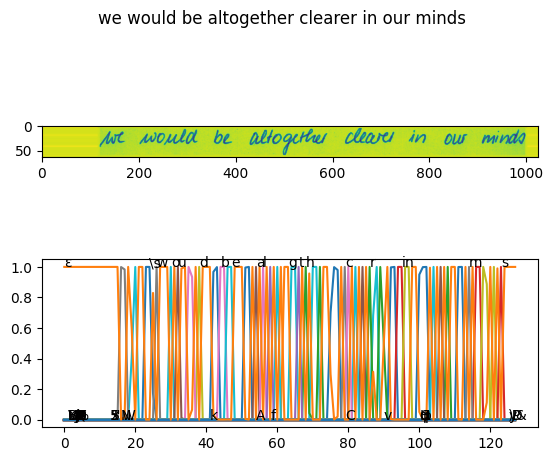

2404/2404 [==============================] - 172s 71ms/step - loss: 2.8830 - ctc_loss: 2.8830 - ctc_accuracy: 0.5032 - pred_CER_metric: 0.0378 - pred_WER_metric: 0.0050 - val_loss: 32.9427 - val_ctc_loss: 32.9427 - val_ctc_accuracy: 0.0876 - val_pred_CER_metric: 0.1152 - val_pred_WER_metric: 0.0152 - lr: 0.0010
Epoch 52/100
2404/2404 [==============================] - 172s 71ms/step - loss: 2.8225 - ctc_loss: 2.8225 - ctc_accuracy: 0.5035 - pred_CER_metric: 0.0375 - pred_WER_metric: 0.0050 - val_loss: 37.0449 - val_ctc_loss: 37.0449 - val_ctc_accuracy: 0.0973 - val_pred_CER_metric: 0.1114 - val_pred_WER_metric: 0.0147 - lr: 0.0010
Epoch 53/100
2404/2404 [==============================] - 171s 71ms/step - loss: 2.6699 - ctc_loss: 2.6699 - ctc_accuracy: 0.5231 - pred_CER_metric: 0.0364 - pred_WER_metric: 0.0048 - val_loss: 37.2284 - val_ctc_loss: 37.2284 - val_ctc_accuracy: 0.1115 - val_pred_CER_metric: 0.1105 - val_pred_WER_metric: 0.0146 - lr: 0.0010
Epoch 54/100
2404/2404 [===========

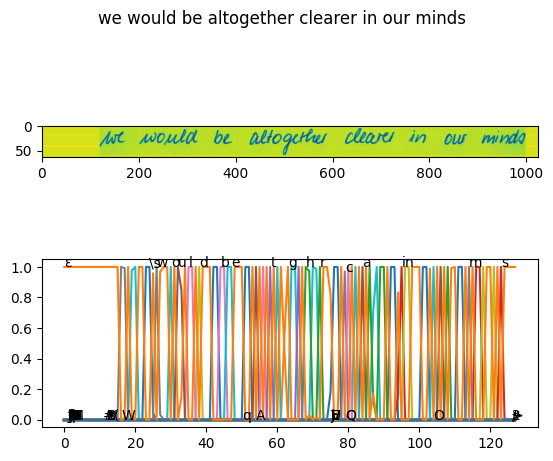

2404/2404 [==============================] - 172s 71ms/step - loss: 2.6444 - ctc_loss: 2.6444 - ctc_accuracy: 0.5351 - pred_CER_metric: 0.0357 - pred_WER_metric: 0.0047 - val_loss: 37.1385 - val_ctc_loss: 37.1385 - val_ctc_accuracy: 0.0996 - val_pred_CER_metric: 0.1084 - val_pred_WER_metric: 0.0143 - lr: 0.0010
Epoch 57/100
2404/2404 [==============================] - 172s 71ms/step - loss: 2.5237 - ctc_loss: 2.5237 - ctc_accuracy: 0.5390 - pred_CER_metric: 0.0362 - pred_WER_metric: 0.0048 - val_loss: 35.4585 - val_ctc_loss: 35.4585 - val_ctc_accuracy: 0.0966 - val_pred_CER_metric: 0.1137 - val_pred_WER_metric: 0.0150 - lr: 0.0010
Epoch 58/100
2404/2404 [==============================] - 174s 73ms/step - loss: 2.5788 - ctc_loss: 2.5788 - ctc_accuracy: 0.5451 - pred_CER_metric: 0.0358 - pred_WER_metric: 0.0048 - val_loss: 35.2557 - val_ctc_loss: 35.2557 - val_ctc_accuracy: 0.0936 - val_pred_CER_metric: 0.1080 - val_pred_WER_metric: 0.0143 - lr: 0.0010
Epoch 59/100
2404/2404 [===========

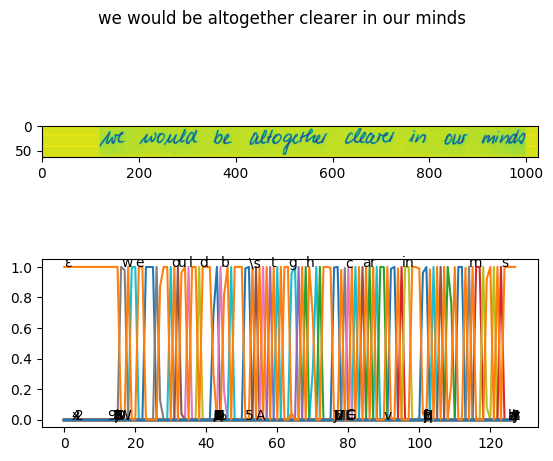

2404/2404 [==============================] - 172s 71ms/step - loss: 2.4333 - ctc_loss: 2.4333 - ctc_accuracy: 0.5612 - pred_CER_metric: 0.0346 - pred_WER_metric: 0.0046 - val_loss: 36.7310 - val_ctc_loss: 36.7310 - val_ctc_accuracy: 0.0943 - val_pred_CER_metric: 0.1116 - val_pred_WER_metric: 0.0148 - lr: 0.0010
Epoch 62/100
2404/2404 [==============================] - 170s 71ms/step - loss: 2.5180 - ctc_loss: 2.5180 - ctc_accuracy: 0.5595 - pred_CER_metric: 0.0353 - pred_WER_metric: 0.0047 - val_loss: 36.7879 - val_ctc_loss: 36.7879 - val_ctc_accuracy: 0.1003 - val_pred_CER_metric: 0.1116 - val_pred_WER_metric: 0.0148 - lr: 0.0010
Epoch 63/100
2404/2404 [==============================] - 171s 71ms/step - loss: 2.4550 - ctc_loss: 2.4550 - ctc_accuracy: 0.5629 - pred_CER_metric: 0.0354 - pred_WER_metric: 0.0047 - val_loss: 36.8473 - val_ctc_loss: 36.8473 - val_ctc_accuracy: 0.0838 - val_pred_CER_metric: 0.1200 - val_pred_WER_metric: 0.0159 - lr: 0.0010
Epoch 64/100
2404/2404 [===========

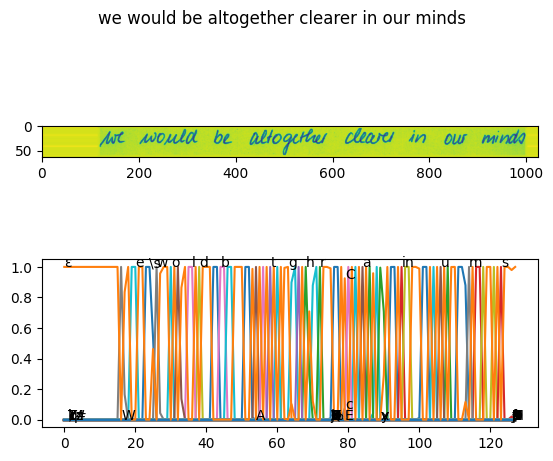

2404/2404 [==============================] - 172s 72ms/step - loss: 2.2493 - ctc_loss: 2.2493 - ctc_accuracy: 0.5960 - pred_CER_metric: 0.0344 - pred_WER_metric: 0.0046 - val_loss: 37.3420 - val_ctc_loss: 37.3420 - val_ctc_accuracy: 0.0958 - val_pred_CER_metric: 0.1123 - val_pred_WER_metric: 0.0149 - lr: 0.0010
Epoch 67/100
2404/2404 [==============================] - 171s 71ms/step - loss: 2.2405 - ctc_loss: 2.2405 - ctc_accuracy: 0.5926 - pred_CER_metric: 0.0342 - pred_WER_metric: 0.0045 - val_loss: 37.4332 - val_ctc_loss: 37.4332 - val_ctc_accuracy: 0.0958 - val_pred_CER_metric: 0.1144 - val_pred_WER_metric: 0.0151 - lr: 0.0010
Epoch 68/100
2404/2404 [==============================] - 171s 71ms/step - loss: 2.2652 - ctc_loss: 2.2652 - ctc_accuracy: 0.5908 - pred_CER_metric: 0.0336 - pred_WER_metric: 0.0045 - val_loss: 38.1380 - val_ctc_loss: 38.1380 - val_ctc_accuracy: 0.1100 - val_pred_CER_metric: 0.1084 - val_pred_WER_metric: 0.0143 - lr: 0.0010
Epoch 69/100
2404/2404 [===========

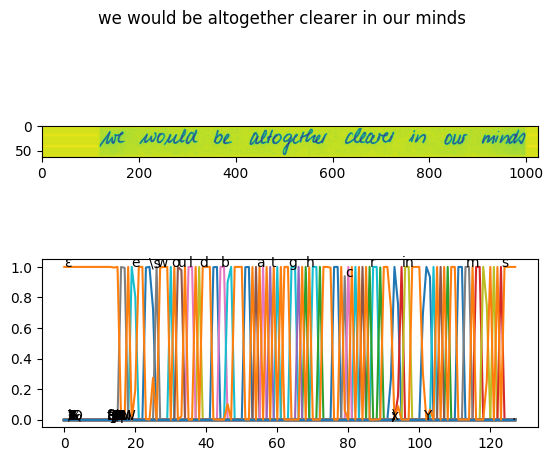

2404/2404 [==============================] - 171s 71ms/step - loss: 2.2521 - ctc_loss: 2.2521 - ctc_accuracy: 0.5978 - pred_CER_metric: 0.0334 - pred_WER_metric: 0.0044 - val_loss: 37.9748 - val_ctc_loss: 37.9748 - val_ctc_accuracy: 0.0996 - val_pred_CER_metric: 0.1085 - val_pred_WER_metric: 0.0144 - lr: 0.0010
Epoch 72/100
2404/2404 [==============================] - 171s 71ms/step - loss: 2.1907 - ctc_loss: 2.1907 - ctc_accuracy: 0.6079 - pred_CER_metric: 0.0335 - pred_WER_metric: 0.0044 - val_loss: 37.8393 - val_ctc_loss: 37.8393 - val_ctc_accuracy: 0.1018 - val_pred_CER_metric: 0.1157 - val_pred_WER_metric: 0.0153 - lr: 0.0010
Epoch 73/100
2404/2404 [==============================] - 170s 71ms/step - loss: 2.0983 - ctc_loss: 2.0983 - ctc_accuracy: 0.6274 - pred_CER_metric: 0.0333 - pred_WER_metric: 0.0044 - val_loss: 36.8785 - val_ctc_loss: 36.8785 - val_ctc_accuracy: 0.1145 - val_pred_CER_metric: 0.1098 - val_pred_WER_metric: 0.0145 - lr: 0.0010
Epoch 74/100
2404/2404 [===========

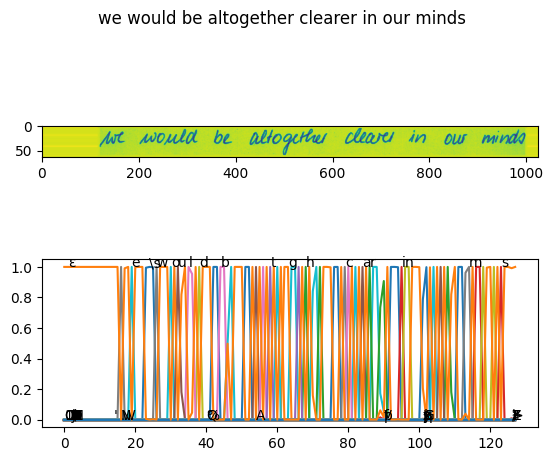

2404/2404 [==============================] - 172s 72ms/step - loss: 2.0688 - ctc_loss: 2.0688 - ctc_accuracy: 0.6302 - pred_CER_metric: 0.0329 - pred_WER_metric: 0.0044 - val_loss: 37.2590 - val_ctc_loss: 37.2590 - val_ctc_accuracy: 0.0996 - val_pred_CER_metric: 0.1117 - val_pred_WER_metric: 0.0148 - lr: 0.0010
Epoch 77/100
2404/2404 [==============================] - 171s 71ms/step - loss: 1.9636 - ctc_loss: 1.9636 - ctc_accuracy: 0.6385 - pred_CER_metric: 0.0327 - pred_WER_metric: 0.0043 - val_loss: 37.4096 - val_ctc_loss: 37.4096 - val_ctc_accuracy: 0.1145 - val_pred_CER_metric: 0.1081 - val_pred_WER_metric: 0.0143 - lr: 0.0010
Epoch 78/100
2404/2404 [==============================] - 170s 71ms/step - loss: 2.1042 - ctc_loss: 2.1042 - ctc_accuracy: 0.6306 - pred_CER_metric: 0.0327 - pred_WER_metric: 0.0043 - val_loss: 37.3813 - val_ctc_loss: 37.3813 - val_ctc_accuracy: 0.1078 - val_pred_CER_metric: 0.1091 - val_pred_WER_metric: 0.0144 - lr: 0.0010
Epoch 79/100
2404/2404 [===========

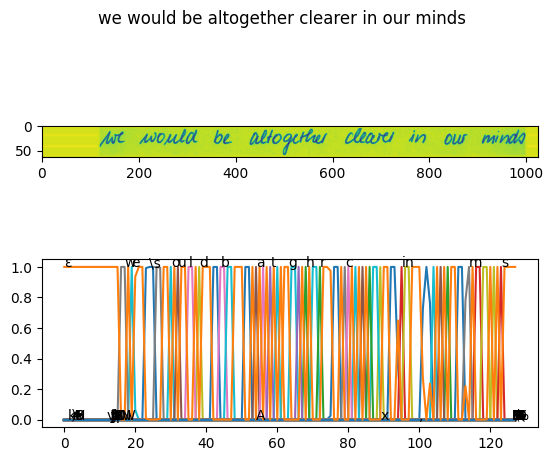

2404/2404 [==============================] - 172s 71ms/step - loss: 1.9129 - ctc_loss: 1.9129 - ctc_accuracy: 0.6552 - pred_CER_metric: 0.0324 - pred_WER_metric: 0.0043 - val_loss: 39.4904 - val_ctc_loss: 39.4904 - val_ctc_accuracy: 0.1220 - val_pred_CER_metric: 0.1078 - val_pred_WER_metric: 0.0143 - lr: 0.0010
Epoch 82/100
2404/2404 [==============================] - 170s 71ms/step - loss: 1.9434 - ctc_loss: 1.9434 - ctc_accuracy: 0.6450 - pred_CER_metric: 0.0323 - pred_WER_metric: 0.0043 - val_loss: 37.3479 - val_ctc_loss: 37.3479 - val_ctc_accuracy: 0.1063 - val_pred_CER_metric: 0.1087 - val_pred_WER_metric: 0.0144 - lr: 0.0010
Epoch 83/100
2404/2404 [==============================] - 170s 71ms/step - loss: 1.9050 - ctc_loss: 1.9050 - ctc_accuracy: 0.6552 - pred_CER_metric: 0.0317 - pred_WER_metric: 0.0042 - val_loss: 39.4923 - val_ctc_loss: 39.4923 - val_ctc_accuracy: 0.1018 - val_pred_CER_metric: 0.1085 - val_pred_WER_metric: 0.0143 - lr: 0.0010
Epoch 84/100
2404/2404 [===========

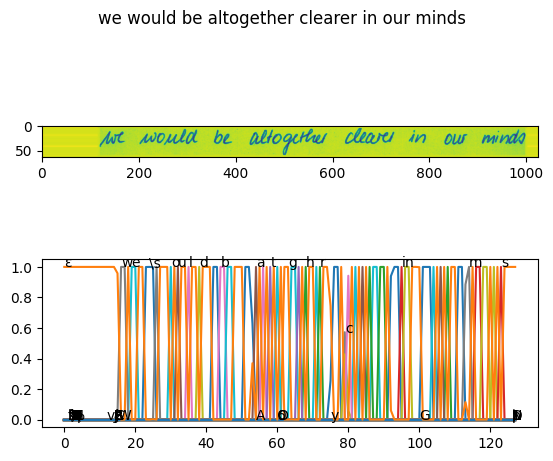

2404/2404 [==============================] - 171s 71ms/step - loss: 1.9610 - ctc_loss: 1.9610 - ctc_accuracy: 0.6533 - pred_CER_metric: 0.0322 - pred_WER_metric: 0.0043 - val_loss: 39.1340 - val_ctc_loss: 39.1340 - val_ctc_accuracy: 0.1145 - val_pred_CER_metric: 0.1061 - val_pred_WER_metric: 0.0140 - lr: 0.0010
Epoch 87/100
2404/2404 [==============================] - 170s 71ms/step - loss: 1.8883 - ctc_loss: 1.8883 - ctc_accuracy: 0.6588 - pred_CER_metric: 0.0321 - pred_WER_metric: 0.0043 - val_loss: 38.7439 - val_ctc_loss: 38.7439 - val_ctc_accuracy: 0.1115 - val_pred_CER_metric: 0.1066 - val_pred_WER_metric: 0.0141 - lr: 0.0010
Epoch 88/100
2404/2404 [==============================] - 171s 71ms/step - loss: 1.8362 - ctc_loss: 1.8362 - ctc_accuracy: 0.6727 - pred_CER_metric: 0.0314 - pred_WER_metric: 0.0042 - val_loss: 39.4330 - val_ctc_loss: 39.4330 - val_ctc_accuracy: 0.1063 - val_pred_CER_metric: 0.1075 - val_pred_WER_metric: 0.0142 - lr: 0.0010
Epoch 89/100
2404/2404 [===========

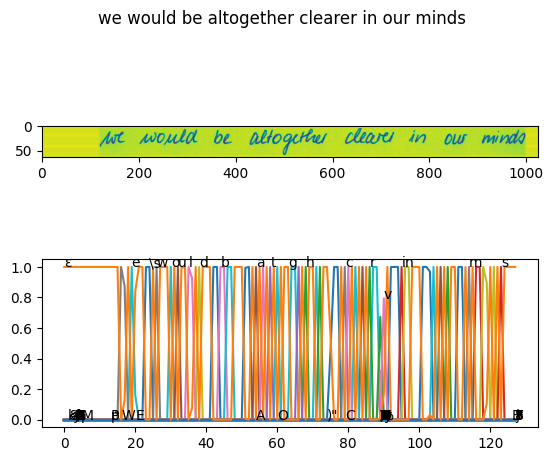

2404/2404 [==============================] - 171s 71ms/step - loss: 1.8837 - ctc_loss: 1.8837 - ctc_accuracy: 0.6707 - pred_CER_metric: 0.0319 - pred_WER_metric: 0.0042 - val_loss: 39.1790 - val_ctc_loss: 39.1790 - val_ctc_accuracy: 0.0966 - val_pred_CER_metric: 0.1094 - val_pred_WER_metric: 0.0145 - lr: 0.0010
Epoch 92/100
2404/2404 [==============================] - 170s 71ms/step - loss: 1.8448 - ctc_loss: 1.8448 - ctc_accuracy: 0.6725 - pred_CER_metric: 0.0313 - pred_WER_metric: 0.0041 - val_loss: 38.8284 - val_ctc_loss: 38.8284 - val_ctc_accuracy: 0.1040 - val_pred_CER_metric: 0.1109 - val_pred_WER_metric: 0.0147 - lr: 0.0010
Epoch 93/100
2404/2404 [==============================] - 170s 71ms/step - loss: 1.8384 - ctc_loss: 1.8384 - ctc_accuracy: 0.6794 - pred_CER_metric: 0.0312 - pred_WER_metric: 0.0041 - val_loss: 41.6312 - val_ctc_loss: 41.6312 - val_ctc_accuracy: 0.1033 - val_pred_CER_metric: 0.1097 - val_pred_WER_metric: 0.0145 - lr: 0.0010
Epoch 94/100
2404/2404 [===========

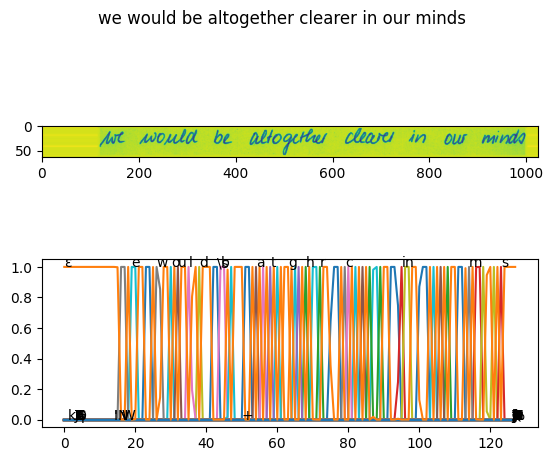

2404/2404 [==============================] - 171s 71ms/step - loss: 1.7781 - ctc_loss: 1.7781 - ctc_accuracy: 0.6809 - pred_CER_metric: 0.0313 - pred_WER_metric: 0.0042 - val_loss: 40.8634 - val_ctc_loss: 40.8634 - val_ctc_accuracy: 0.1078 - val_pred_CER_metric: 0.1084 - val_pred_WER_metric: 0.0143 - lr: 0.0010
Epoch 97/100
2404/2404 [==============================] - 170s 71ms/step - loss: 1.7495 - ctc_loss: 1.7495 - ctc_accuracy: 0.6900 - pred_CER_metric: 0.0310 - pred_WER_metric: 0.0041 - val_loss: 39.3135 - val_ctc_loss: 39.3135 - val_ctc_accuracy: 0.1085 - val_pred_CER_metric: 0.1062 - val_pred_WER_metric: 0.0140 - lr: 0.0010
Epoch 98/100
2404/2404 [==============================] - 170s 71ms/step - loss: 1.7691 - ctc_loss: 1.7691 - ctc_accuracy: 0.6850 - pred_CER_metric: 0.0312 - pred_WER_metric: 0.0041 - val_loss: 39.9478 - val_ctc_loss: 39.9478 - val_ctc_accuracy: 0.1115 - val_pred_CER_metric: 0.1078 - val_pred_WER_metric: 0.0143 - lr: 0.0010
Epoch 99/100
2404/2404 [===========

In [21]:
lim=None
history = train_model.fit([x_train[:lim], y_true[:lim], y_len[:lim], logit_len[:lim]], [y_train[:lim], y_true_categorical[:lim]], 
                          validation_split=0.1, 
                          shuffle=True, 
                          epochs=100,
                          batch_size=5,
                          callbacks=[
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.6, patience=3, min_lr=0.001, mode="min", verbose=1),
    tf.keras.callbacks.LambdaCallback(on_epoch_end=callback_plot)
])

### Measuring performance

In [22]:
def plot_metric(metric_name):
    plt.plot(history.history[metric_name], label=metric_name)
    plt.plot(history.history[f'val_{metric_name}'], label=f"val_{metric_name}")
    plt.legend()
    plt.show()

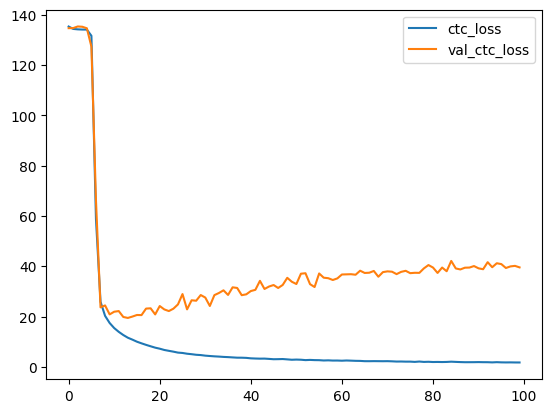

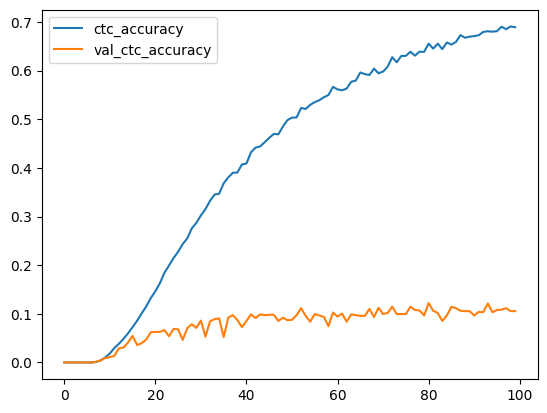

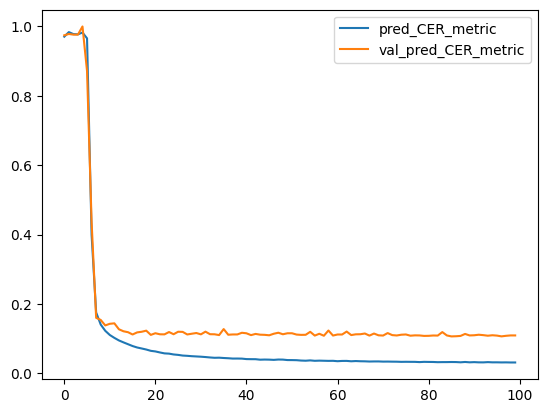

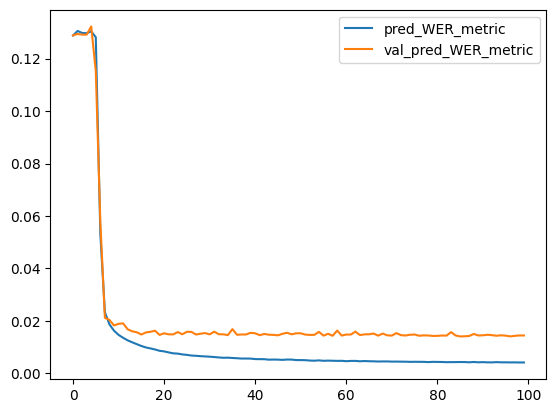

In [23]:
plot_metric("ctc_loss")
plot_metric("ctc_accuracy")
plot_metric("pred_CER_metric")
plot_metric("pred_WER_metric")

### Seeing some predictions

1/1 [==============================] - 0s 22ms/step
(5, 128, 82)


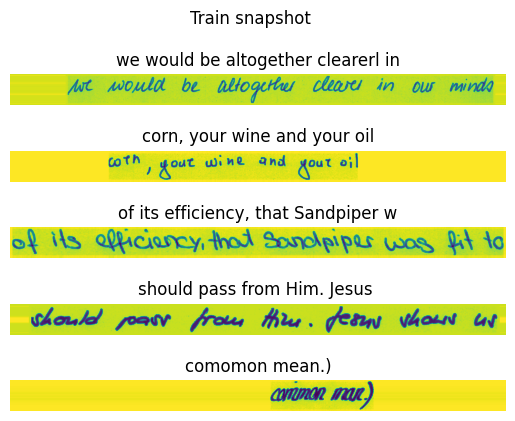

1/1 [==============================] - 0s 21ms/step
(5, 128, 82)


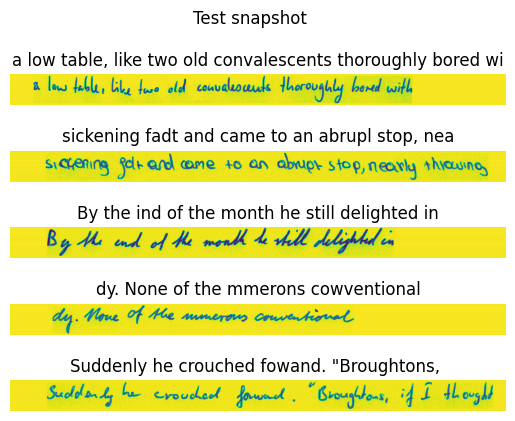

In [24]:
def preview_output(x, yt, title):
    y = recognition_model.predict(x)
    print(y.shape)
    y, _ = tf.keras.backend.ctc_decode(y, np.array([SEQ_LEN]*y.shape[0]), greedy=True)
    y=y[0].numpy()        
    n = x.shape[0]
    fig, axs = plt.subplots(n)
    fig.suptitle(title)    

    for i in range(n):
        axs[i].imshow(x[i])
        real_text = "".join([characters[c] for c in y[i] if 0<=c<len(characters)])        
        axs[i].set_title(f"{real_text}")
        axs[i].axis('off')
    plt.show()
    
preview_output(x_train[:5], y_true[:5], "Train snapshot")
preview_output(x_train[13200:13205], y_true[13200:13205], "Test snapshot")


### For good measures

In [25]:
recognition_model.save_weights("model_crnn_lstm_weights.h5")
recognition_model.save("model_crnn_lstm.keras")